In [63]:
import re
import pandas as pd

LOG_PATTERN = re.compile(
    r"Episode\s+(?P<episode>\d+)\s+\|\s+Reward:\s+(?P<reward>[-\d.]+)\s+\|"
    r"\s+Avg\(100\):\s+(?P<avg100>[-\d.]+)\s+\|"
    r"\s+Epsilon:\s+(?P<epsilon>[-\d.]+)\s+\|"
    r"\s+Best Avg Reward:\s+(?P<best_avg>[-\d.]+)\s+\|"
    r"\s+Best Reward:\s+(?P<best_reward>[-\d.]+)\s+\|"
    r"\s+Steps:\s+(?P<steps>\d+)\s+\|"
    r"\s+Ep Time:\s+(?P<ep_time>[-\d.]+)s"
)

def load_log(path):
    records = []
    with open(path, "r") as f:
        for line in f:
            m = LOG_PATTERN.search(line)
            if m:
                records.append({k: float(v) for k, v in m.groupdict().items()})

    df = pd.DataFrame(records)
    df["episode"] = df["episode"].astype(int)
    df["steps"] = df["steps"].astype(int)
    return df


In [64]:
dqn = load_log("dqn.log")
ddqn = load_log("ddqn.log")


In [65]:
def ema(series, alpha=0.1):
    return series.ewm(alpha=alpha, adjust=False).mean()


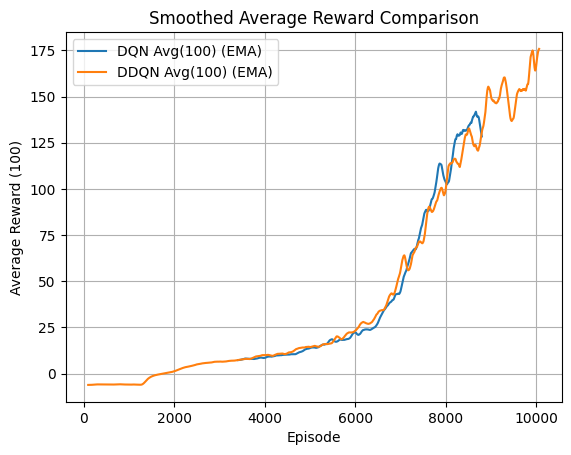

In [66]:
import matplotlib.pyplot as plt

alpha = 0.01

plt.figure()
plt.plot(
    dqn["episode"],
    ema(dqn["avg100"], alpha),
    label="DQN Avg(100) (EMA)"
)
plt.plot(
    ddqn["episode"],
    ema(ddqn["avg100"], alpha),
    label="DDQN Avg(100) (EMA)"
)

plt.xlabel("Episode")
plt.ylabel("Average Reward (100)")
plt.title("Smoothed Average Reward Comparison")
plt.legend()
plt.grid(True)
plt.show()



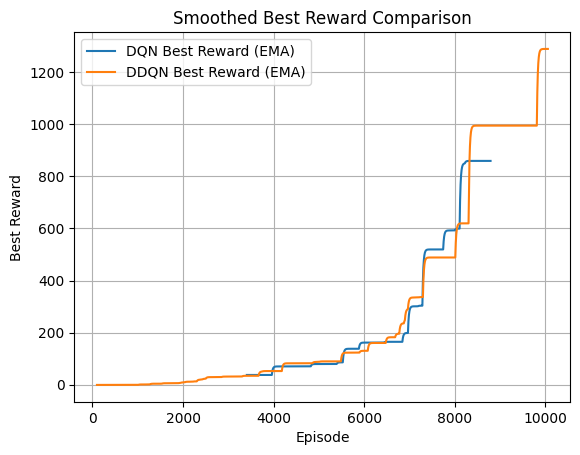

In [67]:
plt.figure()
plt.plot(
    dqn["episode"],
    ema(dqn["best_reward"], alpha=0.05),
    label="DQN Best Reward (EMA)"
)
plt.plot(
    ddqn["episode"],
    ema(ddqn["best_reward"], alpha=0.05),
    label="DDQN Best Reward (EMA)"
)

plt.xlabel("Episode")
plt.ylabel("Best Reward")
plt.title("Smoothed Best Reward Comparison")
plt.legend()
plt.grid(True)
plt.show()


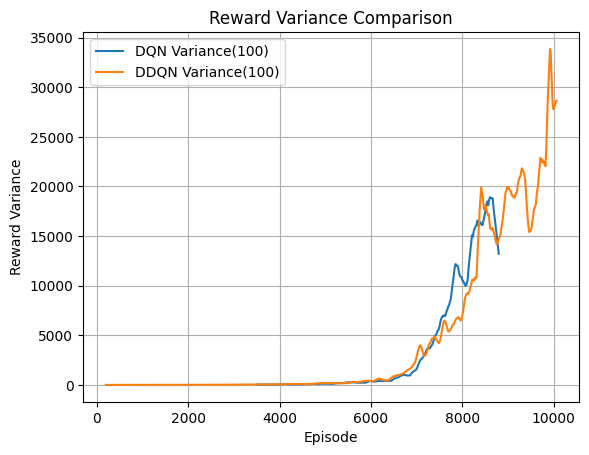

In [75]:
WINDOW = 100

dqn["var100"] = dqn["reward"].rolling(WINDOW).var()
ddqn["var100"] = ddqn["reward"].rolling(WINDOW).var()

plt.figure()
plt.plot(dqn["episode"], ema(dqn["var100"], alpha=0.009), label="DQN Variance(100)")
plt.plot(ddqn["episode"], ema(ddqn["var100"], alpha=0.009), label="DDQN Variance(100)")
plt.xlabel("Episode")
plt.ylabel("Reward Variance")
plt.title("Reward Variance Comparison")
plt.legend()
plt.grid(True)
plt.show()


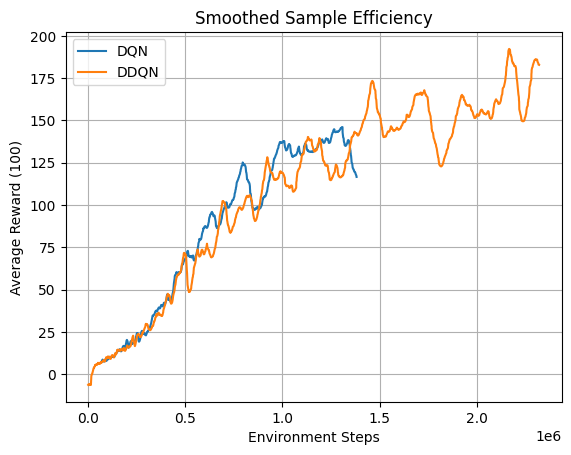

In [76]:
plt.figure()
plt.plot(
    dqn["steps"],
    ema(dqn["avg100"], alpha=0.05),
    label="DQN"
)
plt.plot(
    ddqn["steps"],
    ema(ddqn["avg100"], alpha=0.05),
    label="DDQN"
)

plt.xlabel("Environment Steps")
plt.ylabel("Average Reward (100)")
plt.title("Smoothed Sample Efficiency")
plt.legend()
plt.grid(True)
plt.show()


In [70]:
print("DQN total training time (minutes):",
      dqn["ep_time"].sum() / 60)

print("DDQN total training time (minutes):",
      ddqn["ep_time"].sum() / 60)


DQN total training time (minutes): 879.5783333333333
DDQN total training time (minutes): 1594.0618333333332


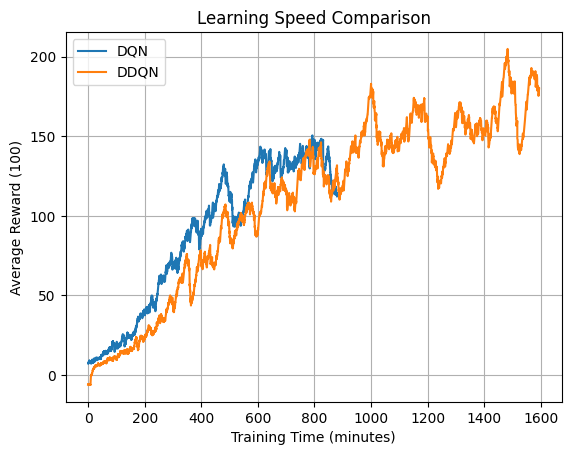

In [71]:
dqn["cum_time"] = dqn["ep_time"].cumsum() / 60
ddqn["cum_time"] = ddqn["ep_time"].cumsum() / 60

plt.figure()
plt.plot(dqn["cum_time"], dqn["avg100"], label="DQN")
plt.plot(ddqn["cum_time"], ddqn["avg100"], label="DDQN")
plt.xlabel("Training Time (minutes)")
plt.ylabel("Average Reward (100)")
plt.title("Learning Speed Comparison")
plt.legend()
plt.grid(True)
plt.show()


In [72]:
summary = pd.DataFrame({
    "Algorithm": ["DQN", "DDQN"],
    "Best Avg(100)": [dqn["avg100"].max(), ddqn["avg100"].max()],
    "Best Reward": [dqn["best_reward"].max(), ddqn["best_reward"].max()],
    "Final Avg(100)": [dqn["avg100"].iloc[-1], ddqn["avg100"].iloc[-1]],
    "Final Variance": [dqn["var100"].iloc[-1], ddqn["var100"].iloc[-1]],
})

print(summary)


  Algorithm  Best Avg(100)  Best Reward  Final Avg(100)  Final Variance
0       DQN         150.52        859.7          112.25     8520.559479
1      DDQN         204.84       1290.1          179.93    29873.350581
